In [1]:
#import import_ipynb
#import imreduction
#import imfit
import sys
import numpy as np
import matplotlib.pyplot as plt #dumped imageio and tifffile packages and used matplotlib to read TIFF files
import seaborn as sns
import pandas as pd
import scipy.signal as signal

from lmfit import models
import math
import random
#from lmfit.models import GaussianModel, SkewedGaussianModel, LorentzianModel, VoigtModel

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

#%%writefile image_analysis.py

This is to test the method seen here https://chrisostrouchov.com/post/peak_fit_xrd_python/ where Chris was trying to detect the specs of the gaussian to make initial guesses easier. Needs further tweaking for our case here.

In [2]:
class Image:
    
    def __init__(self, image):
        self.raw = image
        self.shape= image.shape
        self.x_size= image.shape[0]
        self.y_size= image.shape[1]
        self.subtracted_data= np.array([[0 for y in range(self.y_size)] for x in range(self.x_size)])
        self.profile_x= [0 in range (self.x_size)]
        self.profile_y= [0 in range (self.y_size)]
        
    def subtract_bg(self,bg):
        if (bg.shape == self.shape): 
            for i in range(self.x_size):
                for j in range (self.y_size):
                    if ((self.raw[i][j]>bg[i][j]).all() and (bg[i][j]>=0).all() and (self.raw[i][j]>=0).all()):
                            self.subtracted_data[i][j]= self.raw[i][j]-bg[i][j]
            return self.subtracted_data
                    #else:
                     #   print("Error when subtracting")
        else:
            print("Error: Background image size does not match data size.")
    
    def get_profile(self):
        #PROFILE IN Y
        for i in range(self.y_size): #loop over all y
            sum=0
            for j in range(self.x_size): #loop over all x for each y: gives one number
                sum=sum+self.subtracted_data[j][i]
            self.profile_y.append(sum)
     
        #PROFILE IN X
        for i in range(self.x_size): #loop over all x
            sum=0
            for j in range(self.y_size): #loop over all y for each x: gives one number
                sum=sum+self.subtracted_data[i][j]
            self.profile_x.append(sum)

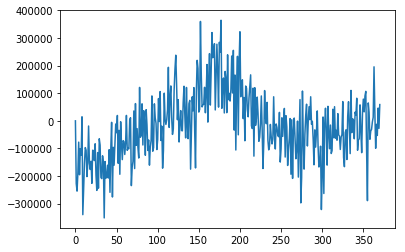

In [18]:
##Can I import based on date and viewer from image details?
im=[0 for i in range(0,20)]
i=0
for j in range (15,35):
    im[i]=plt.imread('tiff_files/Tune1'+str(j)+'_07722018_viewer_D1542_001.tiff')
    i+=1
bg=plt.imread('tiff_files/Tune114_background_003.tiff') #background image


#bg=plt.imread('tiff_files/Tune114_background_003.tiff') #background image
#im[0]=plt.imread('tiff_files/071918_D1542_overnight_nominal__294.tiff')
#bg=plt.imread('tiff_files/071918_D1542_overnight_nominal__295.tiff')

image1=Image(im[7])
##print(image1.subtracted_data)
image1.subtract_bg(bg)
#len(image1.profile_x)
image1.get_profile()
x1 = np.arange(image1.y_size)
x = np.arange(image1.x_size)

#image1.profile_x
profy=np.array(image1.profile_y[1:]-image1.profile_y[1]) #280:330
prof=np.array(image1.profile_x[1:]-image1.profile_x[1]) 

plt.plot(prof)
plt.show()

In [4]:
def generate_model(spec):
    composite_model = None
    params = None
    x = spec['x']
    y = spec['y']
    x_min = np.min(x)
    x_max = np.max(x)
    x_range = x_max - x_min
    y_max = np.max(y)
    for i, basis_func in enumerate(spec['model']):
        prefix = f'm{i}_'
        model = getattr(models, basis_func['type'])(prefix=prefix)
        if basis_func['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']: # for now VoigtModel has gamma constrained to sigma
            model.set_param_hint('sigma', min=1e-6, max=x_range)
            model.set_param_hint('center', min=x_min, max=x_max)
            model.set_param_hint('height', min=1e-6, max=1.1*y_max)
            model.set_param_hint('amplitude', min=1e-6)
            # default guess is horrible!! do not use guess()
            default_params = {
                prefix+'center': x_min + x_range * random.random(),
                prefix+'height': y_max * random.random(),
                prefix+'sigma': x_range * random.random()
            }
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
        if 'help' in basis_func:  # allow override of settings in parameter
            for param, options in basis_func['help'].items():
                model.set_param_hint(param, **options)
        model_params = model.make_params(**default_params, **basis_func.get('params', {}))
        if params is None:
            params = model_params
        else:
            params.update(model_params)
        if composite_model is None:
            composite_model = model
        else:
            composite_model = composite_model + model
    return composite_model, params

/home/sara/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


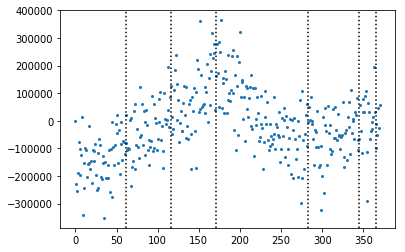

In [21]:
spec = {
    'x': x, #df.index.values,
    'y': prof, #df['count'].values,
    'model': [
        {'type': 'VoigtModel'},
        {'type': 'VoigtModel'},
        {'type': 'VoigtModel'},
        {'type': 'VoigtModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
    ]
}

peaks_found = update_spec_from_peaks(spec, [0, 1, 2, 3, 4, 5, 6], peak_widths=(15,))
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
for i in peaks_found:
    ax.axvline(x=spec['x'][i], c='black', linestyle='dotted')

8


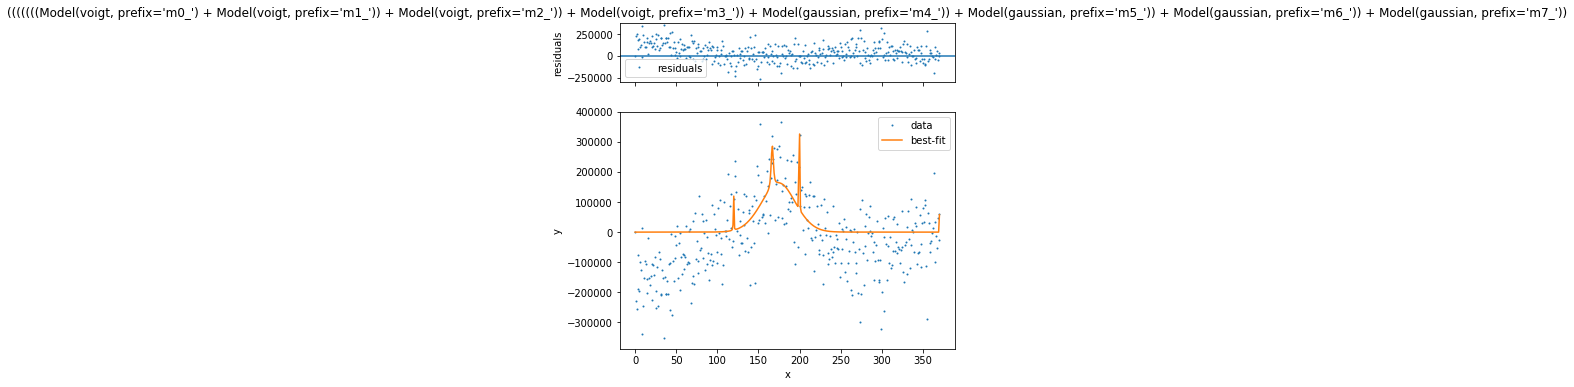

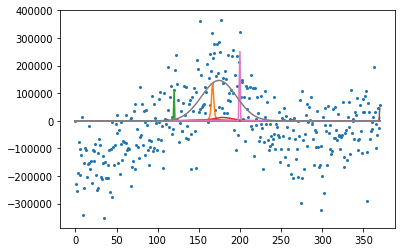

In [23]:

fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
components = output.eval_components(x=spec['x'])
print(len(spec['model']))
for i, model in enumerate(spec['model']):
    ax.plot(spec['x'], components[f'm{i}_'])

In [24]:
#updated spec

def update_spec_from_peaks(spec, model_indicies, peak_widths=(10, 25), **kwargs):
    x = spec['x']
    y = spec['y']
    x_range = np.max(x) - np.min(x)
    peak_indicies = signal.find_peaks_cwt(y, peak_widths)
    np.random.shuffle(peak_indicies)
    for peak_indicie, model_indicie in zip(peak_indicies.tolist(), model_indicies):
        model = spec['model'][model_indicie]
        if model['type'] in ['GaussianModel', 'SkewedGaussian','LorentzianModel', 'VoigtModel']:
            params = {
                'height': y[peak_indicie],
                'sigma': x_range / len(x) * np.min(peak_widths),
                'center': x[peak_indicie]
            }
            if 'params' in model:
                model.update(params)
            else:
                model['params'] = params
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
    return peak_indicies

/home/sara/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


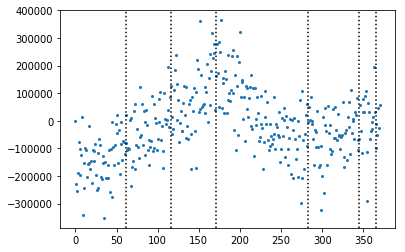

In [29]:
spec = {
    'x': x, #df.index.values,
    'y': prof, #df['count'].values,
    'model': [
        {'type': 'VoigtModel'},
        {'type': 'VoigtModel'},
        {'type': 'VoigtModel'},
        {'type': 'VoigtModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
    ]
}

peaks_found = update_spec_from_peaks(spec, [0, 1, 2, 3, 4, 5, 6], peak_widths=(15,))
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
for i in peaks_found:
    ax.axvline(x=spec['x'][i], c='black', linestyle='dotted')


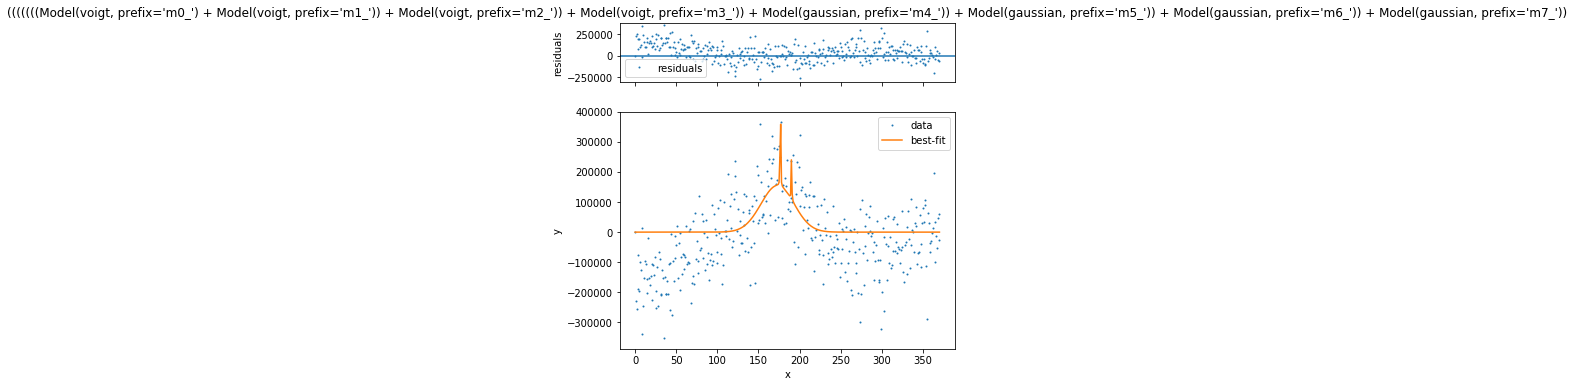

In [30]:
model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig, gridspec = output.plot(data_kws={'markersize':  1})